# Modelo de Clusterização: encontranto o melhor k

In [1]:
# Importações
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.units import inch
import warnings

In [2]:
# Ignorar warnings para melhor visualização
warnings.filterwarnings('ignore')

In [3]:
# --- IMPLEMENTAÇÃO DO GAP STATISTIC ---
def gap_statistic(X, k_range, n_refs=10, random_state=42):
    """
    Implementação do Gap Statistic para determinar o número ideal de clusters
    
    Parâmetros:
    - X: dados normalizados
    - k_range: range de valores k para testar
    - n_refs: número de datasets de referência para gerar
    - random_state: seed para reprodutibilidade
    
    Retorna:
    - gaps: valores do gap statistic para cada k
    - s_k: desvios padrão
    - k_range: range de k testados
    """
    gaps = []
    s_k = []
    
    # Para cada k, calcular o gap statistic
    for k in k_range:
        print(f"Calculando Gap Statistic para K={k}...")
        
        # Treinar KMeans nos dados reais
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        kmeans.fit(X)
        wk = kmeans.inertia_  # Within-cluster sum of squares
        
        # Gerar datasets de referência e calcular Wk para cada um
        wk_refs = []
        for _ in range(n_refs):
            # Gerar dados de referência uniformemente distribuídos
            # dentro do mesmo range dos dados originais
            X_ref = np.random.uniform(
                low=X.min(axis=0), 
                high=X.max(axis=0), 
                size=X.shape
            )
            
            # Treinar KMeans nos dados de referência
            kmeans_ref = KMeans(n_clusters=k, random_state=random_state, n_init=10)
            kmeans_ref.fit(X_ref)
            wk_refs.append(kmeans_ref.inertia_)
        
        # Calcular gap statistic
        gap = np.mean(np.log(wk_refs)) - np.log(wk)
        gaps.append(gap)
        
        # Calcular desvio padrão
        s_k.append(np.std(np.log(wk_refs)) * np.sqrt(1 + 1/n_refs))
    
    return np.array(gaps), np.array(s_k), list(k_range)

In [4]:
# --- MÉTRICA ADICIONAL: CALINSKI-HARABASZ INDEX ---
def calinski_harabasz_analysis(X, k_range):
    """
    Calcula o índice Calinski-Harabasz para diferentes valores de k
    Valores mais altos indicam clusters mais bem definidos
    """
    ch_scores = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        score = calinski_harabasz_score(X, labels)
        ch_scores.append(score)
    return ch_scores

In [5]:
# --- MÉTRICA ADICIONAL: DAVIES-BOULDIN INDEX ---
def davies_bouldin_analysis(X, k_range):
    """
    Calcula o índice Davies-Bouldin para diferentes valores de k
    Valores mais baixos indicam clusters mais bem definidos
    """
    db_scores = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        score = davies_bouldin_score(X, labels)
        db_scores.append(score)
    return db_scores

### 1. Carregando os Dados

In [6]:
# --- Realizando o carregamento ---
df_amazon = pd.read_csv('amazon.csv')

try:
    df = df_amazon.copy()  # Usar o dataframe importado
    print("Dados do df_amazon carregados com sucesso!")
    print(f"Shape dos dados: {df.shape}")
    print(df.head())
except NameError:
    print("Erro: df_amazon não foi encontrado.")
    print("Por favor, certifique-se de que df_amazon foi importado antes de executar este código.")
    print("Gerando dados sintéticos para demonstração...")
    
    # Criar dados sintéticos para demonstração
    np.random.seed(42)
    n_samples = 1000
    
    df = pd.DataFrame({
        'discounted_price': np.random.uniform(10, 1000, n_samples),
        'actual_price': np.random.uniform(15, 1200, n_samples),
        'discount_percentage': np.random.uniform(0, 70, n_samples),
        'rating': np.random.uniform(1, 5, n_samples),
        'rating_count': np.random.randint(1, 10000, n_samples)
    })
    print("Dados sintéticos criados para demonstração!")

Dados do df_amazon carregados com sucesso!
Shape dos dados: (1465, 16)
   product_id                                       product_name  \
0  B07JW9H4J1  Wayona Nylon Braided USB to Lightning Fast Cha...   
1  B098NS6PVG  Ambrane Unbreakable 60W / 3A Fast Charging 1.5...   
2  B096MSW6CT  Sounce Fast Phone Charging Cable & Data Sync U...   
3  B08HDJ86NZ  boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...   
4  B08CF3B7N1  Portronics Konnect L 1.2M Fast Charging 3A 8 P...   

                                            category discounted_price  \
0  Computers&Accessories|Accessories&Peripherals|...             ₹399   
1  Computers&Accessories|Accessories&Peripherals|...             ₹199   
2  Computers&Accessories|Accessories&Peripherals|...             ₹199   
3  Computers&Accessories|Accessories&Peripherals|...             ₹329   
4  Computers&Accessories|Accessories&Peripherals|...             ₹154   

  actual_price discount_percentage rating rating_count  \
0       ₹1,099         

### 2. Pré-processamento dos Dados

In [7]:
# Selecionar colunas numéricas relevantes para segmentação de produtos
features = ['discounted_price', 'discount_percentage', 'rating', 'rating_count']
df_segmentation = df[features].copy()

### Aplicando limpeza robusta para todas as colunas selecionadas

In [8]:
# Função para limpar preços (caso venham como string)
def clean_price(price_str):
    if isinstance(price_str, str):
        return float(price_str.replace('₹', '').replace(',', ''))
    return price_str

In [9]:
# Função para limpar percentual de desconto
def clean_discount_percentage(discount_str):
    if isinstance(discount_str, str):
        return float(discount_str.replace('%', ''))
    return discount_str

In [10]:
# Função para limpar contagem de ratings
def clean_rating_count(count_str):
    if isinstance(count_str, str):
        return int(count_str.replace(',', ''))
    return count_str

In [11]:
# Função para converter valores para numérico de forma segura
def safe_numeric_conversion(value):
    """Converte valores para numérico de forma segura, tratando casos problemáticos"""
    if pd.isna(value):
        return np.nan
    
    # Se já é numérico, retorna como está
    if isinstance(value, (int, float)):
        return float(value)
    
    # Se é string, tenta limpar e converter
    if isinstance(value, str):
        # Remove caracteres problemáticos comuns
        cleaned = value.replace('|', '').replace('₹', '').replace(',', '').replace('%', '').strip()
        
        # Se ficou vazio após limpeza, retorna NaN
        if not cleaned:
            return np.nan
        
        # Tenta converter para float
        try:
            return float(cleaned)
        except ValueError:
            return np.nan
    
    return np.nan

In [12]:
# Aplicar limpeza segura para todas as colunas de features
for col in features:
    if col in df_segmentation.columns:
        print(f"Limpando coluna: {col}")
        
        # Mostrar alguns valores antes da limpeza para debug
        print(f"  Valores únicos antes da limpeza (primeiros 10): {df_segmentation[col].unique()[:10]}")
        
        # Aplicar conversão segura
        df_segmentation[col] = df_segmentation[col].apply(safe_numeric_conversion)
        
        # Mostrar estatísticas após limpeza
        print(f"  Após limpeza - Valores válidos: {df_segmentation[col].notna().sum()}/{len(df_segmentation)}")
        print(f"  Após limpeza - Valores NaN: {df_segmentation[col].isna().sum()}")

Limpando coluna: discounted_price
  Valores únicos antes da limpeza (primeiros 10): ['₹399' '₹199' '₹329' '₹154' '₹149' '₹176.63' '₹229' '₹499' '₹299' '₹219']
  Após limpeza - Valores válidos: 1465/1465
  Após limpeza - Valores NaN: 0
Limpando coluna: discount_percentage
  Valores únicos antes da limpeza (primeiros 10): ['64%' '43%' '90%' '53%' '61%' '85%' '65%' '23%' '50%' '33%']
  Após limpeza - Valores válidos: 1465/1465
  Após limpeza - Valores NaN: 0
Limpando coluna: rating
  Valores únicos antes da limpeza (primeiros 10): ['4.2' '4.0' '3.9' '4.1' '4.3' '4.4' '4.5' '3.7' '3.3' '3.6']
  Após limpeza - Valores válidos: 1464/1465
  Após limpeza - Valores NaN: 1
Limpando coluna: rating_count
  Valores únicos antes da limpeza (primeiros 10): ['24,269' '43,994' '7,928' '94,363' '16,905' '24,871' '15,188' '30,411'
 '1,79,691' '13,391']
  Após limpeza - Valores válidos: 1463/1465
  Após limpeza - Valores NaN: 2


In [13]:
# Verificar se ainda existem valores não numéricos
print("\nVerificando tipos de dados após limpeza:")
print(df_segmentation[features].dtypes)


Verificando tipos de dados após limpeza:
discounted_price       float64
discount_percentage    float64
rating                 float64
rating_count           float64
dtype: object


In [14]:
# Forçar conversão para numérico (coerce irá converter valores problemáticos para NaN)
for col in features:
    if col in df_segmentation.columns:
        df_segmentation[col] = pd.to_numeric(df_segmentation[col], errors='coerce')

print("\nTipos de dados após conversão forçada:")
print(df_segmentation[features].dtypes)


Tipos de dados após conversão forçada:
discounted_price       float64
discount_percentage    float64
rating                 float64
rating_count           float64
dtype: object


In [15]:
# Tratamento de valores ausentes
print("\nTratando valores ausentes...")
for col in features:
    if col in df_segmentation.columns:
        nan_count = df_segmentation[col].isna().sum()
        if nan_count > 0:
            median_val = df_segmentation[col].median()
            df_segmentation[col].fillna(median_val, inplace=True)
            print(f"Preenchidos {nan_count} NaNs na coluna '{col}' com a mediana: {median_val:.2f}")


Tratando valores ausentes...
Preenchidos 1 NaNs na coluna 'rating' com a mediana: 4.10
Preenchidos 2 NaNs na coluna 'rating_count' com a mediana: 5179.00


In [16]:
# Verificação final antes do escalonamento
print("\nVerificação final dos dados:")
print(f"Shape dos dados: {df_segmentation.shape}")
print(f"Valores NaN restantes: {df_segmentation[features].isna().sum().sum()}")
print(f"Tipos de dados finais:")
print(df_segmentation[features].dtypes)


Verificação final dos dados:
Shape dos dados: (1465, 4)
Valores NaN restantes: 0
Tipos de dados finais:
discounted_price       float64
discount_percentage    float64
rating                 float64
rating_count           float64
dtype: object


In [17]:
# Mostrar algumas estatísticas descritivas
print("\nEstatísticas descritivas dos dados limpos:")
print(df_segmentation[features].describe())


Estatísticas descritivas dos dados limpos:
       discounted_price  discount_percentage       rating   rating_count
count       1465.000000          1465.000000  1465.000000    1465.000000
mean        3125.310874            47.691468     4.096587   18277.634812
std         6944.304394            21.635905     0.291574   42727.398216
min           39.000000             0.000000     2.000000       2.000000
25%          325.000000            32.000000     4.000000    1191.000000
50%          799.000000            50.000000     4.100000    5179.000000
75%         1999.000000            63.000000     4.300000   17325.000000
max        77990.000000            94.000000     5.000000  426973.000000


In [18]:
# Escalonamento dos dados
print("\nIniciando escalonamento dos dados...")
try:
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_segmentation[features])
    print("✅ Escalonamento realizado com sucesso!")
    
    print("\nDados escalonados (primeiras 5 linhas):")
    print(pd.DataFrame(X_scaled, columns=features).head())
    
except Exception as e:
    print(f"❌ Erro durante o escalonamento: {e}")
    print("Verificando dados problemáticos...")
    
    # Debug: mostrar valores problemáticos
    for col in features:
        if col in df_segmentation.columns:
            non_numeric = df_segmentation[col].apply(lambda x: not isinstance(x, (int, float, np.number)))
            if non_numeric.any():
                print(f"Valores não numéricos encontrados na coluna '{col}':")
                print(df_segmentation[col][non_numeric].unique())
    
    # Tentar escalonamento após mais uma limpeza
    df_segmentation_clean = df_segmentation[features].copy()
    for col in features:
        df_segmentation_clean[col] = pd.to_numeric(df_segmentation_clean[col], errors='coerce')
        df_segmentation_clean[col].fillna(df_segmentation_clean[col].median(), inplace=True)
    
    X_scaled = scaler.fit_transform(df_segmentation_clean)
    print("✅ Escalonamento realizado após limpeza adicional!")


Iniciando escalonamento dos dados...
✅ Escalonamento realizado com sucesso!

Dados escalonados (primeiras 5 linhas):
   discounted_price  discount_percentage    rating  rating_count
0         -0.392731             0.754029  0.354792      0.140271
1         -0.421541            -0.216911 -0.331373      0.602076
2         -0.421541             1.956146 -0.674456     -0.242307
3         -0.402814             0.245441  0.354792      1.781324
4         -0.428024             0.615323  0.354792     -0.032136


### 3. Determinando o K Ideal

In [19]:
# Definir uma faixa para k (número de clusters)
k_range = range(2, 11)

### a) Método do Cotovelo (Elbow Method)

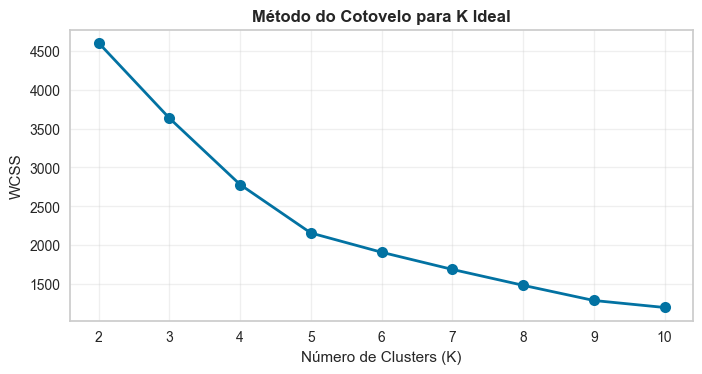

In [39]:
# Plotando o gráfico representativo do Elbow Method
wcss = []
for i in k_range:
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(20, 7))

# Subplot 1: Método do Cotovelo
plt.subplot(2, 3, 1)
plt.plot(k_range, wcss, marker='o', linestyle='-', linewidth=2, markersize=8)
plt.title('Método do Cotovelo para K Ideal', fontsize=12, fontweight='bold')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('WCSS')
plt.xticks(k_range)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('cotovelo_grafico.png', bbox_inches='tight', dpi=300)

### b) Coeficiente de Silhueta (Silhouette Score)

K=2: Coeficiente de Silhueta = 0.2857
K=3: Coeficiente de Silhueta = 0.3056
K=4: Coeficiente de Silhueta = 0.3004
K=5: Coeficiente de Silhueta = 0.3165
K=6: Coeficiente de Silhueta = 0.3286
K=7: Coeficiente de Silhueta = 0.3355
K=8: Coeficiente de Silhueta = 0.3192
K=9: Coeficiente de Silhueta = 0.3049
K=10: Coeficiente de Silhueta = 0.2831


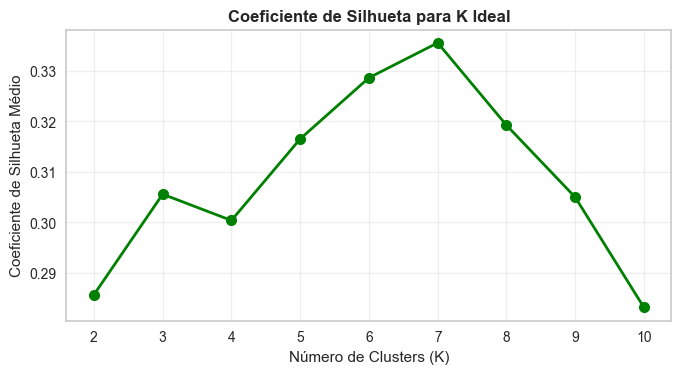

In [21]:
# Plotando o gráfico representativo do Silhouette Score
silhouette_scores = []
for i in k_range:
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(score)
    print(f"K={i}: Coeficiente de Silhueta = {score:.4f}")

# Subplot 2: Coeficiente de Silhueta
plt.figure(figsize=(20, 7))

plt.subplot(2, 3, 2)
plt.plot(k_range, silhouette_scores, marker='o', linestyle='-', linewidth=2, markersize=8, color='green')
plt.title('Coeficiente de Silhueta para K Ideal', fontsize=12, fontweight='bold')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Coeficiente de Silhueta Médio')
plt.xticks(k_range)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('silhueta_grafico.png', bbox_inches='tight', dpi=300)

### c) Gap Statistic (Implementação Própria)

Calculando Gap Statistic para K=2...
Calculando Gap Statistic para K=3...
Calculando Gap Statistic para K=4...
Calculando Gap Statistic para K=5...
Calculando Gap Statistic para K=6...
Calculando Gap Statistic para K=7...
Calculando Gap Statistic para K=8...
Calculando Gap Statistic para K=9...
Calculando Gap Statistic para K=10...


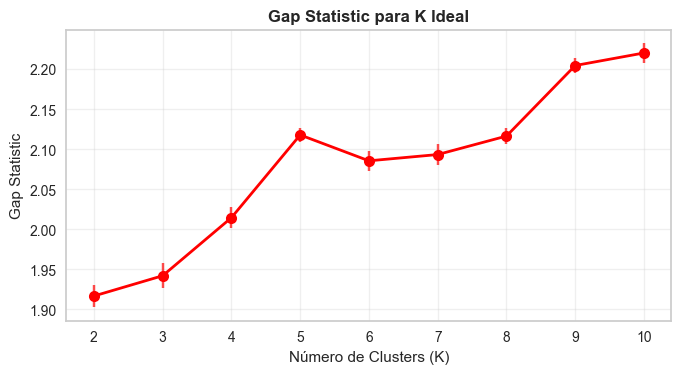

In [22]:
# Plotando o gráfico representativo do Gap Statistic
gaps, errs, k_list = gap_statistic(X_scaled, k_range, n_refs=10)

# Subplot 3: Gap Statistic
plt.figure(figsize=(20, 7))

plt.subplot(2, 3, 3)
plt.plot(k_list, gaps, marker='o', linestyle='-', linewidth=2, markersize=8, color='red')
plt.errorbar(k_list, gaps, yerr=errs, fmt='o', capsize=5, color='red', alpha=0.7)
plt.title('Gap Statistic para K Ideal', fontsize=12, fontweight='bold')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Gap Statistic')
plt.xticks(k_list)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('gap_statistic_grafico.png', bbox_inches='tight', dpi=300)

### d) Calinski-Harabasz Index

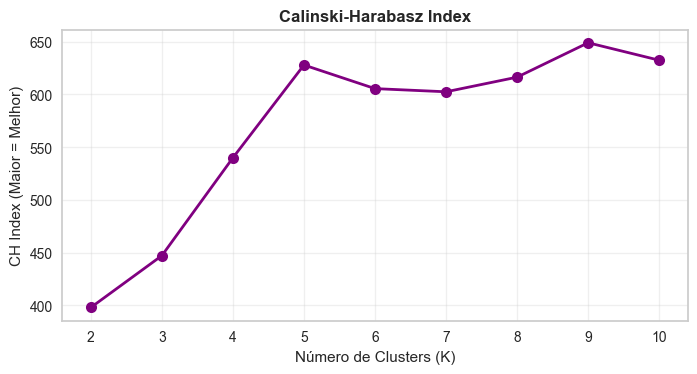

In [23]:
# Plotando o gráfico representativo do Calinski-Harabasz Index
ch_scores = calinski_harabasz_analysis(X_scaled, k_range)

# Subplot 4: Calinski-Harabasz Index
plt.figure(figsize=(20, 7))

plt.subplot(2, 3, 4)
plt.plot(k_range, ch_scores, marker='o', linestyle='-', linewidth=2, markersize=8, color='purple')
plt.title('Calinski-Harabasz Index', fontsize=12, fontweight='bold')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('CH Index (Maior = Melhor)')
plt.xticks(k_range)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('calinski_harabasz_index.png', bbox_inches='tight', dpi=300)

### e) Davies-Bouldin Index

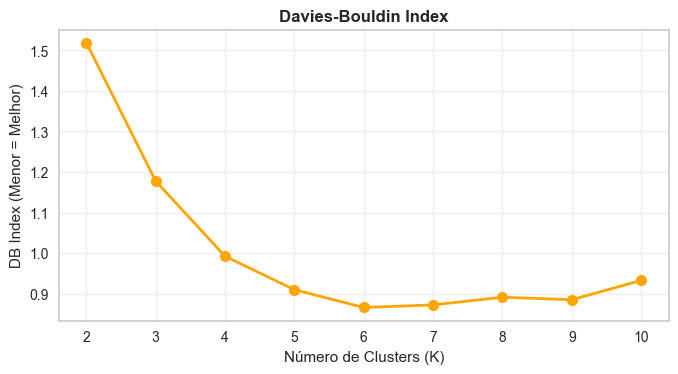

In [24]:
# Plotando o gráfico representativo do Davies-Bouldin Index
db_scores = davies_bouldin_analysis(X_scaled, k_range)

# Subplot 5: Davies-Bouldin Index
plt.figure(figsize=(20, 7))

plt.subplot(2, 3, 5)
plt.plot(k_range, db_scores, marker='o', linestyle='-', linewidth=2, markersize=8, color='orange')
plt.title('Davies-Bouldin Index', fontsize=12, fontweight='bold')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('DB Index (Menor = Melhor)')
plt.xticks(k_range)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('davies_bouldin_index.png', bbox_inches='tight', dpi=300)

### f) Resumo de todas as métricas

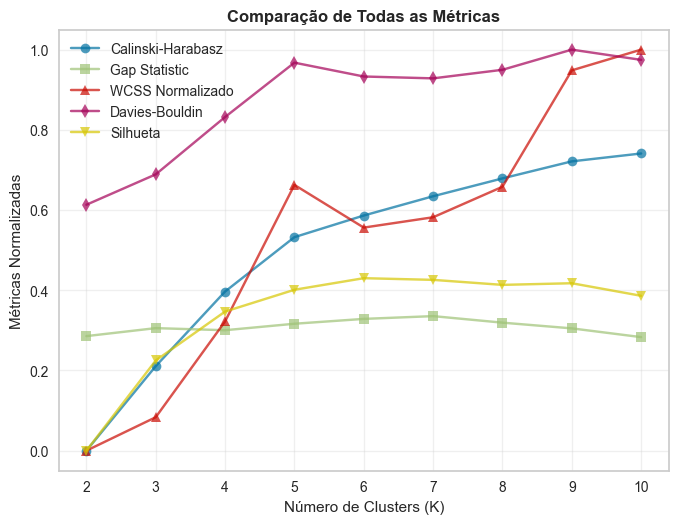

In [25]:
# Plotando o gráfico com resumo de todas as métricas
plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 6)
# Normalizar as métricas para visualização conjunta (0-1)
wcss_norm = 1 - np.array(wcss) / max(wcss)  # Invertido: menor WCSS é melhor
sil_norm = np.array(silhouette_scores)
gap_norm = (np.array(gaps) - min(gaps)) / (max(gaps) - min(gaps))
ch_norm = np.array(ch_scores) / max(ch_scores)
db_norm = 1 - np.array(db_scores) / max(db_scores)  # Invertido: menor DB é melhor

plt.plot(k_range, wcss_norm, marker='o', label='Elbow (norm)', alpha=0.7)
plt.plot(k_range, sil_norm, marker='s', label='Silhouette', alpha=0.7)
plt.plot(k_range, gap_norm, marker='^', label='Gap Stat (norm)', alpha=0.7)
plt.plot(k_range, ch_norm, marker='d', label='CH Index (norm)', alpha=0.7)
plt.plot(k_range, db_norm, marker='v', label='DB Index (norm)', alpha=0.7)

plt.title('Comparação de Todas as Métricas', fontsize=12, fontweight='bold')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Métricas Normalizadas')

plt.savefig('melhor_k.png', dpi=300, format='png')

plt.xticks(k_range)
plt.legend(fontsize=8)
plt.grid(True, alpha=0.3)
plt.legend(['Calinski-Harabasz', 'Gap Statistic', 'WCSS Normalizado', 'Davies-Bouldin', 'Silhueta'], loc='upper left') # Adicione a legenda aqui!
plt.tight_layout()
plt.savefig('comparacao_metricas_grafico.png', bbox_inches='tight', dpi=300)
plt.show()

### 4. Análise Automática e Recomendação

In [26]:
# Encontrar o melhor K para cada métrica
best_k_silhouette = k_range[np.argmax(silhouette_scores)]
best_k_gap = k_list[np.argmax(gaps)]
best_k_ch = k_range[np.argmax(ch_scores)]
best_k_db = k_range[np.argmin(db_scores)]

print(f"\nMelhores K por métrica:")
print(60*'_')
print(f"• Coeficiente de Silhueta: K = {best_k_silhouette} (score: {max(silhouette_scores):.4f})")
print(f"• Gap Statistic: K = {best_k_gap} (gap: {max(gaps):.4f})")
print(f"• Calinski-Harabasz Index: K = {best_k_ch} (score: {max(ch_scores):.2f})")
print(f"• Davies-Bouldin Index: K = {best_k_db} (score: {min(db_scores):.4f})")

# Capturando as strings de saída:
output_string = f"\nMelhores K por métrica:\n" \
                f"• Coeficiente de Silhueta: K = {best_k_silhouette} (score: {max(silhouette_scores):.4f})\n" \
                f"• Gap Statistic: K = {best_k_gap} (gap: {max(gaps):.4f})\n" \
                f"• Calinski-Harabasz Index: K = {best_k_ch} (score: {max(ch_scores):.2f})\n" \
                f"• Davies-Bouldin Index: K = {best_k_db} (score: {min(db_scores):.4f})"



Melhores K por métrica:
____________________________________________________________
• Coeficiente de Silhueta: K = 7 (score: 0.3355)
• Gap Statistic: K = 10 (gap: 2.2202)
• Calinski-Harabasz Index: K = 9 (score: 649.04)
• Davies-Bouldin Index: K = 6 (score: 0.8657)


In [27]:
# Calcular consenso
k_votes = [best_k_silhouette, best_k_gap, best_k_ch, best_k_db]
from collections import Counter
k_consensus = Counter(k_votes).most_common(1)[0][0]

print(f"\n🎯 RECOMENDAÇÃO BASEADA EM CONSENSO: K = {k_consensus}")
print(f"   (Votação: {dict(Counter(k_votes))})")

# Análise detalhada do K recomendado
print(f"\n📊 ANÁLISE DETALHADA PARA K = {k_consensus}:")
kmeans_final = KMeans(n_clusters=k_consensus, random_state=42, n_init=10)
labels = kmeans_final.fit_predict(X_scaled)

print(f"• Silhouette Score: {silhouette_score(X_scaled, labels):.4f}")
print(f"• Calinski-Harabasz Index: {calinski_harabasz_score(X_scaled, labels):.2f}")
print(f"• Davies-Bouldin Index: {davies_bouldin_score(X_scaled, labels):.4f}")
print(f"• Inércia (WCSS): {kmeans_final.inertia_:.2f}")


🎯 RECOMENDAÇÃO BASEADA EM CONSENSO: K = 7
   (Votação: {7: 1, 10: 1, 9: 1, 6: 1})

📊 ANÁLISE DETALHADA PARA K = 7:
• Silhouette Score: 0.3355
• Calinski-Harabasz Index: 602.55
• Davies-Bouldin Index: 0.8720
• Inércia (WCSS): 1684.09


In [28]:
# Distribuição dos clusters
unique, counts = np.unique(labels, return_counts=True)
print(f"\n📈 DISTRIBUIÇÃO DOS CLUSTERS:")
for i, count in zip(unique, counts):
    percentage = (count / len(labels)) * 100
    print(f"   Cluster {i}: {count} produtos ({percentage:.1f}%)")


📈 DISTRIBUIÇÃO DOS CLUSTERS:
   Cluster 0: 106 produtos (7.2%)
   Cluster 1: 574 produtos (39.2%)
   Cluster 2: 14 produtos (1.0%)
   Cluster 3: 270 produtos (18.4%)
   Cluster 4: 37 produtos (2.5%)
   Cluster 5: 388 produtos (26.5%)
   Cluster 6: 76 produtos (5.2%)


### 5. Análise dos Clusters Resultantes

In [29]:
# Adicionar labels ao dataframe original
df_analysis = df_segmentation.copy()
df_analysis['cluster'] = labels

# Calcular centros dos clusters (desescalonados)
cluster_centers_scaled = kmeans_final.cluster_centers_
cluster_centers = scaler.inverse_transform(cluster_centers_scaled)
df_centers = pd.DataFrame(cluster_centers, columns=features)

print("\n📋 CENTROS DOS CLUSTERS (valores médios):")
print(df_centers.round(2))

print("\n🔍 ESTATÍSTICAS DETALHADAS POR CLUSTER:")
for i in range(k_consensus):
    cluster_data = df_analysis[df_analysis['cluster'] == i]
    print(f"\n--- CLUSTER {i} ({len(cluster_data)} produtos) ---")
    print(cluster_data[features].describe().round(2))


📋 CENTROS DOS CLUSTERS (valores médios):
   discounted_price  discount_percentage  rating  rating_count
0          14455.25                32.05    4.15      16035.90
1           1021.72                63.75    4.19       9677.24
2           2309.43                48.14    4.20     346515.79
3           1294.36                54.47    3.65       5358.02
4          36999.86                30.84    4.28       9636.16
5           1650.84                24.04    4.21      11160.51
6            901.67                53.07    4.18     112335.39

🔍 ESTATÍSTICAS DETALHADAS POR CLUSTER:

--- CLUSTER 0 (106 produtos) ---
       discounted_price  discount_percentage  rating  rating_count
count            106.00               106.00  106.00        106.00
mean           14455.25                32.05    4.15      16035.90
std             4561.95                11.85    0.14      14716.82
min             7799.00                 0.00    3.80          7.00
25%            10499.00                25.00 

### 6. Visualização dos Clusters

In [30]:
print(f"\n--- Visualização dos Clusters usando PCA ---")

# Redução de dimensionalidade para visualização
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 5))


--- Visualização dos Clusters usando PCA ---


<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

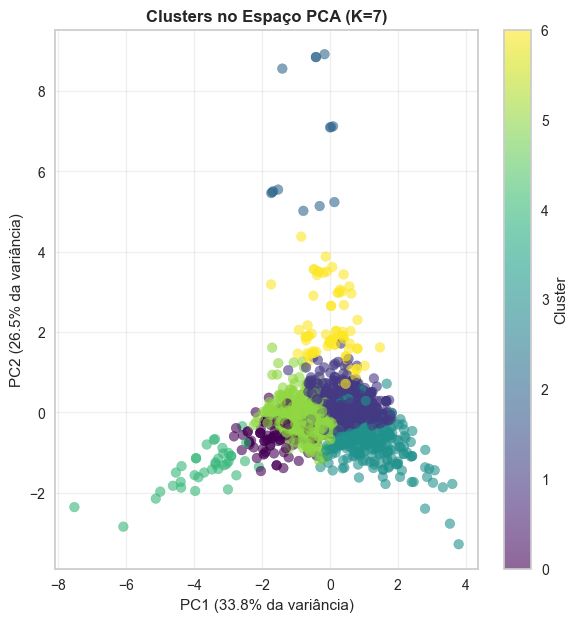

In [31]:
# Subplot 1: Clusters no espaço PCA
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.title(f'Clusters no Espaço PCA (K={k_consensus})', fontsize=12, fontweight='bold')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} da variância)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} da variância)')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)

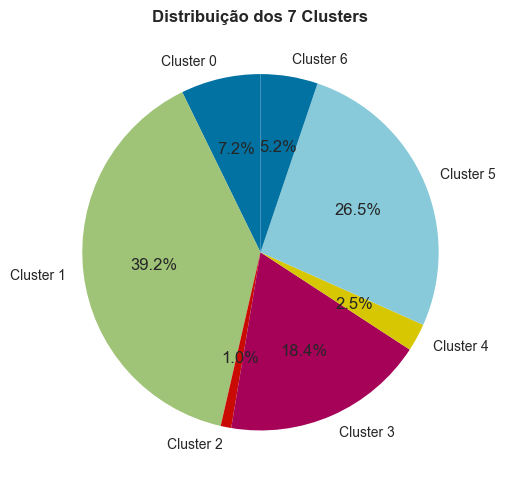


✅ ANÁLISE COMPLETA FINALIZADA!
💡 K recomendado: 7 clusters
🎯 Pronto para implementar estratégias de marketing personalizadas!


In [32]:
# Subplot 2: Distribuição dos clusters
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 2)
plt.pie(counts, labels=[f'Cluster {i}' for i in unique], autopct='%1.1f%%', startangle=90)
plt.title(f'Distribuição dos {k_consensus} Clusters', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.savefig('distribuicao_7_clusters.png', bbox_inches='tight', dpi=300)
plt.show()

print(f"\n✅ ANÁLISE COMPLETA FINALIZADA!")
print(f"💡 K recomendado: {k_consensus} clusters")
print(f"🎯 Pronto para implementar estratégias de marketing personalizadas!")

### Criando o relatório para apresentação

In [33]:
# Criando a variável recomendação

recomendacao_texto = """
### Análise e Recomendação do K Ideal

Com base na análise das diversas métricas de validação de clusters, observa-se que não há um valor único de K que otimize todas elas simultaneamente, o que é comum em problemas de clusterização. No entanto, podemos identificar um valor de compromisso:

* **Métricas que buscam máxima separação e densidade (Calinski-Harabasz e Gap Statistic)** tendem a indicar K's maiores (K=9 e K=10, respectivamente). Isso sugere uma estrutura de dados mais granular.
* **Métricas que avaliam coesão e separação com menor complexidade (Silhueta e Davies-Bouldin)** apontam para K's ligeiramente menores (K=7 e K=6, respectivamente).

**Conclusão e Recomendação:**

Considerando um balanço entre a qualidade do agrupamento e a interpretabilidade dos clusters, **K=7** emerge como um forte candidato. Embora não seja o pico absoluto para todas as métricas, ele oferece um desempenho sólido para o Coeficiente de Silhueta e o Davies-Bouldin, e ainda apresenta valores muito bons para o Calinski-Harabasz e o Gap Statistic.

A escolha final de K=7 visa proporcionar clusters bem definidos que sejam, ao mesmo tempo, significativos para análise e aplicação prática, evitando a complexidade excessiva de um número muito elevado de grupos.
"""

In [41]:
# Gerando o relatório em PDF

def generate_cluster_report(output_filename, metrics_output_text, recommendation_text, k_consensus_val):
    doc = SimpleDocTemplate(output_filename, pagesize=letter)
    styles = getSampleStyleSheet()
    story = []

    # Título do Relatório
    story.append(Paragraph("Relatório de Análise de Clusterização para K Ideal", styles['h1']))
    story.append(Spacer(1, 0.2 * inch))
    story.append(Paragraph("Este relatório apresenta a análise das métricas de validação de clusters e a distribuição final dos clusters.", styles['Normal']))
    story.append(Spacer(1, 0.2 * inch))

    # --- Seção de Métricas de Validação ---
    story.append(Paragraph("1. Análise de Métricas para Determinação do K Ideal", styles['h2']))
    story.append(Spacer(1, 0.2 * inch))

    # Gráfico do Método do Cotovelo
    story.append(Paragraph("Método do Cotovelo (Elbow Method)", styles['h3']))
    story.append(Spacer(1, 0.1 * inch))
    try:
        img_cotovelo = Image('cotovelo_grafico.png', width=5*inch, height=3.5*inch)
        story.append(img_cotovelo)
        story.append(Spacer(1, 0.1 * inch))
        story.append(Paragraph("O Método do Cotovelo (WCSS) busca o ponto onde a soma dos quadrados intra-cluster (WCSS) começa a desacelerar significativamente. Visualmente, o 'cotovelo' aponta para um K onde os ganhos de agrupamento adicionais são marginais.", styles['Normal']))
        story.append(Spacer(1, 0.2 * inch))
    except FileNotFoundError:
        story.append(Paragraph("Gráfico do Método do Cotovelo não encontrado.", styles['Italic']))
        story.append(Spacer(1, 0.2 * inch))

    # Gráfico Coeficiente de Silhueta
    story.append(Paragraph("Coeficiente de Silhueta (Silhouette Score)", styles['h3']))
    story.append(Spacer(1, 0.1 * inch))
    try:
        img_silhueta = Image('silhueta_grafico.png', width=5*inch, height=3.5*inch)
        story.append(img_silhueta)
        story.append(Spacer(1, 0.1 * inch))
        story.append(Paragraph("O Coeficiente de Silhueta mede o quão similar um objeto é ao seu próprio cluster em comparação com outros clusters. Valores próximos a 1 indicam uma boa separação e coesão, 0 indica sobreposição, e -1 indica uma possível atribuição incorreta.", styles['Normal']))
        story.append(Spacer(1, 0.2 * inch))
    except FileNotFoundError:
        story.append(Paragraph("Gráfico Coeficiente de Silhueta não encontrado.", styles['Italic']))
        story.append(Spacer(1, 0.2 * inch))

    # Gráfico Gap Statistic
    story.append(Paragraph("Gap Statistic", styles['h3']))
    story.append(Spacer(1, 0.1 * inch))
    try:
        img_gap = Image('gap_statistic_grafico.png', width=5*inch, height=3.5*inch)
        story.append(img_gap)
        story.append(Spacer(1, 0.1 * inch))
        story.append(Paragraph("O Gap Statistic compara a dispersão intra-cluster dos dados reais com a dispersão esperada de uma distribuição de referência aleatória. Valores mais altos do Gap Statistic indicam uma melhor estrutura de agrupamento.", styles['Normal']))
        story.append(Spacer(1, 0.2 * inch))
    except FileNotFoundError:
        story.append(Paragraph("Gráfico Gap Statistic não encontrado.", styles['Italic']))
        story.append(Spacer(1, 0.2 * inch))

    # --- Adicionando Calinski-Harabasz Index ---
    story.append(Paragraph("Calinski-Harabasz Index", styles['h3']))
    story.append(Spacer(1, 0.1 * inch))
    try:
        img_ch = Image('calinski_harabasz_index.png', width=5*inch, height=3.5*inch) # Usando o nome do arquivo que você forneceu
        story.append(img_ch)
        story.append(Spacer(1, 0.1 * inch))
        story.append(Paragraph("O Índice Calinski-Harabasz (também conhecido como Variance Ratio Criterion) mede a razão da dispersão inter-cluster para a dispersão intra-cluster. Um valor alto indica clusters densos e bem separados, buscando a maximização desta métrica.", styles['Normal']))
        story.append(Spacer(1, 0.2 * inch))
    except FileNotFoundError:
        story.append(Paragraph("Gráfico Calinski-Harabasz Index não encontrado. Certifique-se de que 'calinski_harabasz_index.png' foi salvo.", styles['Italic']))
        story.append(Spacer(1, 0.2 * inch))

    # --- Adicionando Davies-Bouldin Index ---
    story.append(Paragraph("Davies-Bouldin Index", styles['h3']))
    story.append(Spacer(1, 0.1 * inch))
    try:
        img_db = Image('davies_bouldin_index.png', width=5*inch, height=3.5*inch) # Usando o nome do arquivo que você forneceu
        story.append(img_db)
        story.append(Spacer(1, 0.1 * inch))
        story.append(Paragraph("O Índice Davies-Bouldin mede a similaridade média entre cada cluster e seu cluster mais similar. Um valor baixo indica que os clusters são bem separados e compactos, buscando a minimização desta métrica.", styles['Normal']))
        story.append(Spacer(1, 0.2 * inch))
    except FileNotFoundError:
        story.append(Paragraph("Gráfico Davies-Bouldin Index não encontrado. Certifique-se de que 'davies_bouldin_index.png' foi salvo.", styles['Italic']))
        story.append(Spacer(1, 0.2 * inch))


    # Gráfico de Comparação de Todas as Métricas (continua sendo importante para a visão geral)
    story.append(Paragraph("Resumo Comparativo de Todas as Métricas", styles['h3']))
    story.append(Spacer(1, 0.1 * inch))
    try:
        img_comparacao = Image('comparacao_metricas_grafico.png', width=6.5*inch, height=5*inch) # Ajuste o tamanho
        story.append(img_comparacao)
        story.append(Spacer(1, 0.1 * inch))
        story.append(Paragraph("Este gráfico apresenta a comparação normalizada de diversas métricas de validação de clusters (Calinski-Harabasz, Gap Statistic, WCSS, Davies-Bouldin e Silhueta) em função do número de clusters (K). Ele oferece uma visão consolidada do desempenho de diferentes K's através de múltiplas perspectivas.", styles['Normal']))
        story.append(Spacer(1, 0.2 * inch))
    except FileNotFoundError:
        story.append(Paragraph("Gráfico de Comparação de Métricas não encontrado.", styles['Italic']))
        story.append(Spacer(1, 0.2 * inch))

    # Resultados da Análise Automática por Métrica
    story.append(Paragraph("Resultados da Análise Automática por Métrica", styles['h3']))
    story.append(Spacer(1, 0.1 * inch))
    for line in metrics_output_text.split('\n'):
        if line.strip():
            story.append(Paragraph(line, styles['Normal']))
    story.append(Spacer(1, 0.2 * inch))

    # Recomendação Final do K
    story.append(Paragraph("Recomendação para a Escolha do K Ideal", styles['h3']))
    story.append(Spacer(1, 0.1 * inch))
    for line in recommendation_text.split('\n'):
        if line.strip():
            clean_line = line.replace('###', '').replace('**', '').replace('*', '').strip()
            if clean_line:
                story.append(Paragraph(clean_line, styles['Normal']))
    story.append(Spacer(1, 0.2 * inch))

    # --- Seção de Distribuição dos Clusters Finais ---
    story.append(Paragraph(f"2. Distribuição dos {k_consensus_val} Clusters Finais", styles['h2']))
    story.append(Spacer(1, 0.2 * inch))
    try:
        img_distribuicao = Image('distribuicao_7_clusters.png', width=5*inch, height=5*inch) # Nome corrigido aqui
        story.append(img_distribuicao)
        story.append(Spacer(1, 0.1 * inch))
        story.append(Paragraph(f"Este gráfico de pizza ilustra a distribuição percentual de cada um dos {k_consensus_val} clusters finais identificados, fornecendo uma visão da proporção de dados em cada grupo.", styles['Normal']))
        story.append(Spacer(1, 0.2 * inch))
    except FileNotFoundError:
        story.append(Paragraph("Gráfico de Distribuição dos Clusters não encontrado. Certifique-se de que 'distribuicao_7_clusters.png' foi salvo.", styles['Italic']))
        story.append(Spacer(1, 0.2 * inch))

    # Rodapé
    story.append(Spacer(1, 0.5 * inch))
    story.append(Paragraph("Relatório Gerado Automaticamente.", styles['Italic']))

    doc.build(story)

# Chamar a função para gerar o relatório
# Certifique-se de que `output_string`, `recomendacao_texto` e `k_consensus`
# são definidos no seu notebook antes de chamar esta função.
# k_consensus seria o K final escolhido, que você mencionou ser 7.
# Os dados para output_string e recomendacao_texto devem ser calculados e definidos
# antes desta chamada.
# Exemplo (substitua pelos seus valores reais):
# k_consensus = 7
# output_string = "..." # Seu texto de saída das métricas
# recomendacao_texto = "..." # Seu texto de recomendação

generate_cluster_report('relatorio_clusters.pdf', output_string, recomendacao_texto, k_consensus)
print("\nRelatório PDF 'relatorio_clusters.pdf' gerado com sucesso!")


Relatório PDF 'relatorio_clusters.pdf' gerado com sucesso!
